<a href="https://colab.research.google.com/github/nyp-sit/iti107/blob/main/session-1/train_convnet_with_custom_data_(solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Using Convolutional Neural Network for Custom Data

In this exercise, you will apply what you learnt in the previous lab and apply it on a more realistic dataset (as compared to the toy dataset such as Fashion MNIST). Also, you will learn to create `tf.data.Dataset` and use them for training.

We will be using a smaller subset of the original [Cats vs. Dogs dataset] (https://www.kaggle.com/c/dogs-vs-cats/data) from Kaggle. 

## Download the dataset

Download the dataset from https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/cats_and_dogs_subset.tar.gz and unzip into a folder. You can use [tf.keras.utils.get_file()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) which will download and unzip for you, or just run wget and unzip using bash.



In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import os

In [2]:
## Complete your code here 
dataset_URL = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/datasets/cats_and_dogs_subset.tar.gz'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_subset.tar.gz', origin=dataset_URL, extract=True, cache_dir='.')
dataset_dir = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_subset")

In [3]:
dogs_dir = os.path.join(dataset_dir, "dogs")
cats_dir = os.path.join(dataset_dir, "cats")
print('total dog images:', len(os.listdir(dogs_dir)))
print('total cat images:', len(os.listdir(cats_dir)))

total dog images: 1500
total cat images: 1500


## Generate Datasets

Generates a training and validation dataset from image files in the directory. In the previous exercise, when we use `keras.datasets` to load the Fashion MNIST dataset, the data are already splitted to train and test(validation) set and are loaded as numpy array. However, if you are working with your own dataset, you will probably have a bunch of image files in a filesystem and you will need to do your train/test split. Also, if you have a large dataset, it is not efficient to make all the images loaded as numpy array, as you will probably run out of memory soon. A more efficient way is to use [`tf.data.Datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API to load the data (recommended way). 

Keras provides an easy-to-use function [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) that behaves like the old good [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) but uses the more efficient `tf.data.Datasets`

You will need to organize your images into a folder structure like shown here. Assuming you have two classes A and B, your folder should look like below: 

```
data
  classA
    imageA1.jpg
    imageA2.jpg 
  classB
    imageB1.jpg
    imageB2.jpg
```

You can then use the following code to create a training dataset and validation dataset, both as tf.data.Dataset: 

```python
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

```


In [30]:
# Complete your code here 

# specify the desired input size to the convolutional neural network
image_size = (200, 200)

# specify the training batch size
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.



The label will be inferred from the name of the subdirectory `classA (label 0)` and `classB (label 1)`, where the numeric label is assigned according to alphanumeric order.   

You can look at the assignment using the `class_names` variable.

In [31]:
train_ds.class_names

['cats', 'dogs']

## Visualize sample images from your train or validation dataset

Visualize some of the images in training dataset.  Also find out what label (0 or 1) is given to cat and dog respectively. You can use the `take(1)` method of `tf.data.Dataset` to take 1 batch of samples (image + label). You can then iterate over this to retrieve each sample. For example: 

```python
for images, labels in train_ds.take(1): 
    for i in range(len(images): 
       ## do something 
       
```

You can also convert the dataset into a list if you prefer to work with list. For example: 

```python
samples = list(train_ds.take(1))
images, labels = samples[0]   

```

`samples[0]` is a tuple and the length of the images and labels is the batch size.

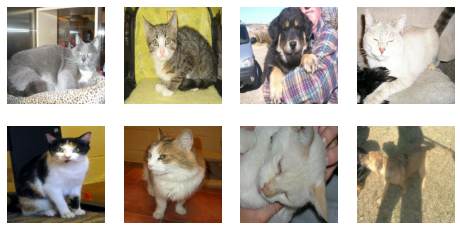

In [32]:
import matplotlib.pyplot as plt

# complete your code here

plt.figure(figsize=(8, 4))

# loop through the batch of samples and display them 
for images, _ in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Build your Model

Build your model and compile your model with appropriate loss function and optimizer. You can choose any combination of layers and units but observe general design pattern (e.g. VGG-16). Also try to use the functional API instead of sequential API. 

In our previous exercise, we normalize our numpy array (images) to between 0 and 1, as a separate pre-processing step. You can make scaling as part of the model layer so that the scaling can be done as part of the model to take advantage of any GPU acceleration (if available). Keras provides [`Rescaling` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) for this purpose.


In [33]:
## complete your code here, use functional API model

image_size = (200, 200, 3)

def make_model():

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=image_size))
    model.add(keras.layers.Rescaling(scale=1./255))
    model.add(keras.layers.Conv2D(32, (3, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

model = make_model()

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 198, 198, 32)     128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 198, 198, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 97, 97, 64)       

## Train the model

Train your model. Specify the callbacks you want (e.g. Tensorboard, ModelCheckpoint, etc).  
As you will be using `tf.data.Dataset` as your dataset, instead of images and labels arrays, you can call your `model.fit()` by simply 
`model.fit(train_ds, validation_data=val_ds, ....)` 

In [34]:
# Complete your code here

def create_tb_callback(): 

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
	    import time
	    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
	    return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[create_tb_callback(), model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - 10s 59ms/step - loss: 0.7968 - accuracy: 0.6167 - val_loss: 0.8494 - val_accuracy: 0.4867
Epoch 2/30
150/150 [==============================] - 8s 55ms/step - loss: 0.5890 - accuracy: 0.6833 - val_loss: 0.9781 - val_accuracy: 0.4867
Epoch 3/30
150/150 [==============================] - 9s 62ms/step - loss: 0.5371 - accuracy: 0.7283 - val_loss: 0.6421 - val_accuracy: 0.6317
Epoch 4/30
150/150 [==============================] - 9s 57ms/step - loss: 0.4937 - accuracy: 0.7483 - val_loss: 0.5853 - val_accuracy: 0.6917
Epoch 5/30
150/150 [==============================] - 8s 56ms/step - loss: 0.4470 - accuracy: 0.7958 - val_loss: 0.5521 - val_accuracy: 0.7050
Epoch 6/30
150/150 [==============================] - 9s 58ms/step - loss: 0.4065 - accuracy: 0.8204 - val_loss: 0.5554 - val_accuracy: 0.7333
Epoch 7/30
150/150 [==============================] - 9s 59ms/step - loss: 0.3421 - accuracy: 0.8537 - val_loss: 0.6773 - val_accuracy: 0.721

In [35]:
model.load_weights('best_checkpoint')
model.evaluate(val_ds)

38/38 [==============================] - 1s 20ms/step - loss: 0.6574 - accuracy: 0.7850


[0.6574100852012634, 0.7850000262260437]

## Visualize the training and validation loss

Visualize your training and validation loss. What do you observe? Is there any overfitting/underfitting problem? Modify your model to address the problem, if any.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

In [39]:
import ipywidgets as widgets

uploader = widgets.FileUpload(
    accept='image/*',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

display(uploader)


FileUpload(value={}, accept='image/*', description='Upload')

In [40]:
key = next(iter(uploader.value))

with open(key, "w+b") as file:
    file.write(uploader.data[0])

img = tf.keras.preprocessing.image.load_img(
    filename, target_size=(img_height, img_width)
)

# we convert the image to numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Although we only have single image, however our model expected data in batches
# so we will need to add in the batch axis too
img_array = tf.expand_dims(img_array, 0) # Create a batch

# we load the model saved earlier and do the inference 
predictions = model(img_array)
print(predictions)
if predictions[0] > 0.5: 
    print('It is a dog')
else:
    print('It is a cat')

StopIteration: ignored